In [6]:
import random
import csv
import math
import numpy as np
import time
import operator
import matplotlib.pyplot as plt
import pickle
import heapq

# Load Stored Live Edges

In [7]:
live_edges_20k_point001_point3 = pickle.load(open("live_edges_20k_point001_point3", "rb"))

live_edges_20k_point001_point5 = pickle.load(open("live_edges_20k_point001_point5", "rb"))

live_edges_20k_point005_point3 = pickle.load(open("live_edges_20k_point005_point3", "rb"))

live_edges_20k_point005_point5 = pickle.load(open("live_edges_20k_point005_point5", "rb"))


# CELF

In [8]:
def celf_population_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_nodes)
    
    print('Running CELF to minimize population affected w/ live edges')
    results = open("CELF_population_live_edge.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    final_population = []
    final_runtimes = []
    
    rewards_so_far = sum( [ len(infected_ids)  for infected_ids in lists_infected_nodes ]) / float(runs_per_marginal_node) # population affected w/o detectors
    
    marginals = [] # heap to track marginals
    start_time = time.time()
    
    # we are calculated population saved
    # if the detector is in the infected nodes, we take the index of the detector b/c the infected nodes are in chronological order + 1 - length to represent how many we saved
    # if not, we just take 0 b/c we didnt save any
    # select the first node by exhuastively computing all marginal benefits
    # our metric = (population affected w/ detector) - population affected w/o detector
    # we are trying to minimize this metric
    for potential_detector in range(1,n+1): # calculate marginals for each node
        runs = [infected_ids.index(potential_detector)+1 if potential_detector in infected_ids else len(infected_ids) for infected_ids in lists_infected_nodes]
        heapq.heappush(marginals, (sum(runs)/float(runs_per_marginal_node) - rewards_so_far, potential_detector) )

        
    if debug: # gonna pop a couple
        top_5 = []
        for i in range(5):
            top_5.append( heapq.heappop(marginals) )
        for marginal in top_5:
            print(marginal)
        for i in range(5):
            heapq.heappush(marginals, top_5[i])
    
    best_tuple = heapq.heappop(marginals)
    best_node = best_tuple[1]
    marginal = best_tuple[0]
    rewards_so_far = marginal + rewards_so_far
    
    selected_detectors = [best_node] # we have found our first best node
    
    print("We have our first best node: ")
    print(selected_detectors)
    runtime = (time.time() - start_time) / 60
    print("Runtime (minutes) = " + str( runtime))
    final_population.append(rewards_so_far)
    final_runtimes.append(runtime)
    
    results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginal) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next 19 detectors
        
        if debug:
            print("Trying to find the " + str(i+1) + "th detector")
        
        # need to re-evaluate the top node once, at least
        old_top_tuple = heapq.heappop(marginals)
        old_top_node = old_top_tuple[1]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        # lazily evaluate for the top node
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_ids = lists_infected_nodes[run]
            if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                    if infected_node in new_detectors:
                        runs.append(infected_ids.index(infected_node) + 1)
                        break # since we found the earliest detection
            else: # outbreak not detected, so everyone got affected
                runs.append(len(infected_ids))
        
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
        
        if debug: # gonna pop a couple
            top_5 = []
            for i in range(5):
                top_5.append( heapq.heappop(marginals) )
            for marginal in top_5:
                print(marginal)
            for i in range(5):
                heapq.heappush(marginals, top_5[i])

        new_top_tuple = heapq.heappop(marginals)
        new_top_node = new_top_tuple[1]
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [] # records number of runs
            for run in range(runs_per_marginal_node): # go thru the runs
                infected_ids = lists_infected_nodes[run]
                if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                    for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                        if infected_node in new_detectors:
                            runs.append(infected_ids.index(infected_node) + 1)
                            break
                else: # outbreak not detected, so everyone got affected
                    runs.append(len(infected_ids))            
            heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
           
            new_top_tuple = heapq.heappop(marginals)
            new_top_node = new_top_tuple[1]
        
        
        
        best_node = new_top_node
        
        print("After doing CELF, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node))
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + new_top_tuple[0] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(new_top_tuple[0]) + '\t' + str(runtime) + '\n')
        final_population.append(rewards_so_far)
        final_runtimes.append(runtime)
        print("Population affected so far: " + str(rewards_so_far))
        print("Runtime (minutes) = " + str(runtime))
                 
    results.close()
    
    return final_population, final_runtimes, selected_detectors

# Pure Social Score

In [9]:
def social_population_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors):

    final_population = []
    final_runtimes = []
    
    with open("socialScore_modified_unpruned.txt") as social_file:
        lines = social_file.readlines()
        social_score_nodes = []
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )
    runs_per_marginal_node = len(lists_infected_nodes)
            
    rewards_so_far = 0
    marginal = 0
    start_time = time.time()
    selected_detectors = []
    for next_detector in range(num_detectors):
        selected_detectors.append(social_score_nodes[next_detector]) # add the next detector
        
        runs = [] # records number of runs
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_ids = lists_infected_nodes[run]
            if bool(set(selected_detectors) & set(infected_ids)): # detector is in the set of infected ids
                for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                    if infected_node in selected_detectors:
                        runs.append(infected_ids.index(infected_node) + 1)
                        break
            else: # outbreak not detected, so everyone got affected
                runs.append(len(infected_ids))
        population = sum(runs) / float(runs_per_marginal_node)
        marginal = population - rewards_so_far
        rewards_so_far = population
        final_population.append(rewards_so_far)
        print("After doing Social Score, we have found the " + str(next_detector+1) + "th detector = " + str(social_score_nodes[next_detector]))
        print("Population affected so far: " + str(rewards_so_far))
        print("Marginal gain = " + str(marginal))
        runtime = (time.time() - start_time) / 60
        print("Runtime (minutes) = " + str(runtime))
        final_runtimes.append(runtime)
    
    return final_population, final_runtimes



# Speed Up

In [10]:
def speedup_population_live_edges(p_initial_infect, p_infect, lists_infected_nodes, num_detectors, social_score_file, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_nodes)
    final_population = []
    final_runtimes = []
    
    print('Running Speedup to minimize population affected w/ live edges')
    results = open("Speedup_population_live_edge.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    rewards_so_far = sum( [ len(infected_ids)  for infected_ids in lists_infected_nodes ]) / float(runs_per_marginal_node) # population affected w/o detectors
    
    marginals = [] # heap to track marginals
    
    # how we keep track of the social score nodes
    social_score_nodes = []
    with open(social_score_file) as social_file:
        lines = social_file.readlines()
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )   
   
    
    look_ahead = int(math.sqrt(n)) # how much we look ahead
    start_time = time.time()
    
    # we are calculated population saved
    # if the detector is in the infected nodes, we take the index of the detector b/c the infected nodes are in chronological order + 1 - length to represent how many we saved
    # if not, we just take 0 b/c we didnt save any
    # select the first node by exhuastively computing all marginal benefits
    # our metric = (population affected w/ detector) - population affected w/o detector
    # we are trying to minimize this metric
    for potential_detector in social_score_nodes[:look_ahead]: # calculate marginals for each node
        runs = [infected_ids.index(potential_detector)+1 if potential_detector in infected_ids else len(infected_ids) for infected_ids in lists_infected_nodes]
        heapq.heappush(marginals, (sum(runs)/float(runs_per_marginal_node) - rewards_so_far, potential_detector) )

        
    
    best_tuple = heapq.heappop(marginals)
    best_node = best_tuple[1]
    marginal = best_tuple[0]
    rewards_so_far = marginal + rewards_so_far
    
    selected_detectors = [best_node] # we have found our first best node
    
    print("We have our first best node: ")
    print(selected_detectors)
    runtime = (time.time() - start_time) / 60
    print("Runtime (minutes) = " + str( runtime))
    final_population.append(rewards_so_far)
    final_runtimes.append(runtime)
    
    results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginal) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next num_detectors-1 detectors
        
        if debug:
            print("Trying to find the " + str(i+1) + "th detector")
        
        # add one new detector from social score
        new_detectors=list(selected_detectors)
        additional_detector = social_score_nodes[look_ahead - 1 + i]
        new_detectors.append(additional_detector)
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_ids = lists_infected_nodes[run]
            if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                    if infected_node in new_detectors:
                        runs.append(infected_ids.index(infected_node) + 1)
                        break # since we found the earliest detection
            else: # outbreak not detected, so everyone got affected
                runs.append(len(infected_ids))
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, additional_detector))
        
        
        # need to re-evaluate the top node once, at least
        old_top_tuple = heapq.heappop(marginals)
        old_top_node = old_top_tuple[1]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        # lazily evaluate for the top node
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_ids = lists_infected_nodes[run]
            if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                    if infected_node in new_detectors:
                        runs.append(infected_ids.index(infected_node) + 1)
                        break # since we found the earliest detection
            else: # outbreak not detected, so everyone got affected
                runs.append(len(infected_ids))
        
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))

        new_top_tuple = heapq.heappop(marginals)
        new_top_node = new_top_tuple[1]
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [] # records number of runs
            for run in range(runs_per_marginal_node): # go thru the runs
                infected_ids = lists_infected_nodes[run]
                if bool(set(new_detectors) & set(infected_ids)): # detector is in the set of infected ids
                    for infected_node in infected_ids: # let's go thru the infected IDs to see which one is affected
                        if infected_node in new_detectors:
                            runs.append(infected_ids.index(infected_node) + 1)
                            break
                else: # outbreak not detected, so everyone got affected
                    runs.append(len(infected_ids))            
            heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
           
            new_top_tuple = heapq.heappop(marginals)
            new_top_node = new_top_tuple[1]
        
        
        
        best_node = new_top_node
        
        print("After doing speed up, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node))
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + new_top_tuple[0] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(new_top_tuple[0]) + '\t' + str(runtime) + '\n')
        final_population.append(rewards_so_far)
        final_runtimes.append(runtime)
        print("Population affected so far: " + str(rewards_so_far))
        print("Runtime (minutes) = " + str(runtime))
        
        
        
            
    results.close()
    
    return final_population, final_runtimes, selected_detectors

# Comparisons

P_infect = 0.3, p_initial = 0.001

In [11]:
celf_population_point001_point3, celf_population_runtimes_point001_point3, selected_detectors = celf_population_live_edges(0.001, 0.3, live_edges_20k_point001_point3[:10000], 50, debug=False )


Running CELF to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 1.442711353302002
After doing CELF, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 4.7224
Runtime (minutes) = 3.02797114054362
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 3.9813
Runtime (minutes) = 3.44291007121404
After doing CELF, we have found the 4th detector w/ best marginal gain = 1706
Population affected so far: 3.6564
Runtime (minutes) = 3.8487972180048624
After doing CELF, we have found the 5th detector w/ best marginal gain = 1159
Population affected so far: 3.4155
Runtime (minutes) = 4.063555204868317
After doing CELF, we have found the 6th detector w/ best marginal gain = 1144
Population affected so far: 3.2031
Runtime (minutes) = 4.21073328256607
After doing CELF, we have found the 7th detector w/ best marginal gain = 1287
Population affected so far: 3.0723
R

In [10]:
social_population_point001_point3, social_population_runtimes_point001_point3 = social_population_live_edges(0.001, 0.3, live_edges_20k_point001_point3[:10000], 50 )


After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 11.8771
Marginal gain = 11.8771
Runtime (minutes) = 0.0023784677187601725
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 10.8146
Marginal gain = -1.0625
Runtime (minutes) = 0.004850943883260091
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 4.4573
Marginal gain = -6.3573
Runtime (minutes) = 0.0070086320241292315
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 4.3306
Marginal gain = -0.12670000000000048
Runtime (minutes) = 0.00838097333908081
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 4.2665
Marginal gain = -0.06409999999999982
Runtime (minutes) = 0.009715501467386882
After doing Social Score, we have found the 6th detector = 585
Population affected so far: 4.2301
Marginal gain = -0.036399999999999544
Runtime (minutes)

After doing Social Score, we have found the 49th detector = 702
Population affected so far: 2.6178
Marginal gain = -0.0026000000000001577
Runtime (minutes) = 0.10231764316558838
After doing Social Score, we have found the 50th detector = 350
Population affected so far: 2.6101
Marginal gain = -0.007699999999999818
Runtime (minutes) = 0.10471153656641642


In [11]:
speedup_population_point001_point3, speedup_population_runtimes_point001_point3, selected_detectors = speedup_population_live_edges(0.001, 0.3, live_edges_20k_point001_point3[:10000], 50 , "socialScore_modified_unpruned.txt" )


Running Speedup to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 0.013904070854187012
After doing speed up, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 4.7224
Runtime (minutes) = 0.08388307094573974
After doing speed up, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 3.9813
Runtime (minutes) = 0.10626644293467204
After doing speed up, we have found the 4th detector w/ best marginal gain = 1706
Population affected so far: 3.6564
Runtime (minutes) = 0.12776537736256918
After doing speed up, we have found the 5th detector w/ best marginal gain = 1159
Population affected so far: 3.4155
Runtime (minutes) = 0.14272122383117675
After doing speed up, we have found the 6th detector w/ best marginal gain = 1144
Population affected so far: 3.2031
Runtime (minutes) = 0.14926405747731528
After doing speed up, we have found the 7th detector w/ best marginal gain =

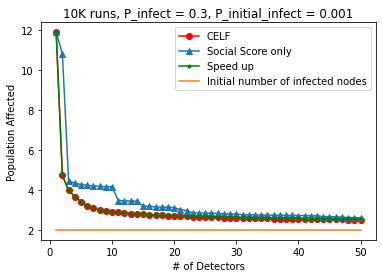

In [12]:
plt.plot(range(1, 51), celf_population_point001_point3, label="CELF", marker="o", color="red")
plt.plot(range(1, 51), social_population_point001_point3, label="Social Score only", marker="^")
plt.plot(range(1, 51), speedup_population_point001_point3, label="Speed up", marker=".", color="green")
plt.plot(range(1,51), np.ones(50)*2, label="Initial number of infected nodes")
plt.title("10K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Population Affected")
plt.xlabel("# of Detectors")
plt.legend()

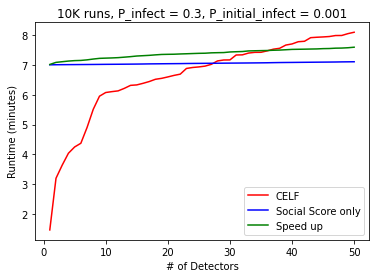

In [13]:
plt.plot(range(1,51), celf_population_runtimes_point001_point3, label="CELF", color="red")
plt.plot(range(1,51), [time + 7 for time in social_population_runtimes_point001_point3], label="Social Score only", color="blue")
plt.plot(range(1,51), [time + 7 for time in speedup_population_runtimes_point001_point3] , label="Speed up", color="green")
plt.title("10K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.005, p_infect = 0.5

In [14]:
celf_population_point005_point5, celf_population_runtimes_point005_point5, selected_detectors = celf_population_live_edges(0.005, 0.5, live_edges_20k_point005_point5[:10000], 50, debug=False )


Running CELF to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 4.468795065085093
After doing CELF, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 16.3498
Runtime (minutes) = 9.665913577874502
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 14.6939
Runtime (minutes) = 14.52194671233495
After doing CELF, we have found the 4th detector w/ best marginal gain = 1159
Population affected so far: 13.8772
Runtime (minutes) = 14.878262138366699
After doing CELF, we have found the 5th detector w/ best marginal gain = 1706
Population affected so far: 13.1246
Runtime (minutes) = 15.00705999135971
After doing CELF, we have found the 6th detector w/ best marginal gain = 1144
Population affected so far: 12.5149
Runtime (minutes) = 15.192504636446635
After doing CELF, we have found the 7th detector w/ best marginal gain = 246
Population affected so far: 

In [15]:
social_population_point005_point5, social_population_runtimes_point005_point5 = social_population_live_edges(0.005, 0.5, live_edges_20k_point005_point5[:10000], 50 )


After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 29.6462
Marginal gain = 29.6462
Runtime (minutes) = 0.005669844150543213
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 27.4859
Marginal gain = -2.1602999999999994
Runtime (minutes) = 0.010378472010294596
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 15.6666
Marginal gain = -11.8193
Runtime (minutes) = 0.017580060164133708
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 15.3346
Marginal gain = -0.33200000000000074
Runtime (minutes) = 0.02180075248082479
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 15.1599
Marginal gain = -0.17469999999999963
Runtime (minutes) = 0.02631101608276367
After doing Social Score, we have found the 6th detector = 585
Population affected so far: 15.0751
Marginal gain = -0.08479999999999954
Runt

After doing Social Score, we have found the 48th detector = 713
Population affected so far: 10.2905
Marginal gain = -0.0472999999999999
Runtime (minutes) = 0.27815711895624795
After doing Social Score, we have found the 49th detector = 702
Population affected so far: 10.2672
Marginal gain = -0.023299999999998988
Runtime (minutes) = 0.28543228705724083
After doing Social Score, we have found the 50th detector = 350
Population affected so far: 10.2341
Marginal gain = -0.03310000000000102
Runtime (minutes) = 0.2916924039522807


In [16]:
speedup_population_point005_point5, speedup_population_runtimes_point005_point5, selected_detectors = speedup_population_live_edges(0.005, 0.5, live_edges_20k_point005_point5[:10000], 50, "socialScore_modified_unpruned.txt", debug=False )


Running Speedup to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 0.03151772419611613
After doing speed up, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 16.3498
Runtime (minutes) = 0.22683749596277872
After doing speed up, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 14.6939
Runtime (minutes) = 0.28316800196965536
After doing speed up, we have found the 4th detector w/ best marginal gain = 1159
Population affected so far: 13.8772
Runtime (minutes) = 0.34655899604161583
After doing speed up, we have found the 5th detector w/ best marginal gain = 1706
Population affected so far: 13.1246
Runtime (minutes) = 0.36400205294291177
After doing speed up, we have found the 6th detector w/ best marginal gain = 1144
Population affected so far: 12.5149
Runtime (minutes) = 0.3884481072425842
After doing speed up, we have found the 7th detector w/ best marginal gai

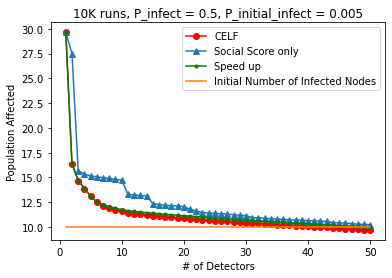

In [17]:
plt.plot(range(1, 51), celf_population_point005_point5, label="CELF", color="red", marker="o")
plt.plot(range(1, 51), social_population_point005_point5, label="Social Score only", marker="^")
plt.plot(range(1, 51), speedup_population_point005_point5, label="Speed up", marker=".", color="green")
plt.plot(range(1,51), np.ones(50)*10, label="Initial Number of Infected Nodes")
plt.title("10K runs, P_infect = 0.5, P_initial_infect = 0.005")
plt.ylabel("Population Affected")
plt.xlabel("# of Detectors")
plt.legend()

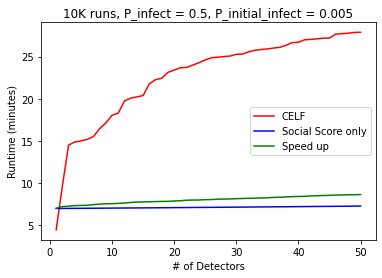

In [18]:
plt.plot(range(1,51), celf_population_runtimes_point005_point5, label="CELF", color="red")
plt.plot(range(1,51), [time + 7 for time in social_population_runtimes_point005_point5], label="Social Score only", color="blue")
plt.plot(range(1,51), [time + 7 for time in speedup_population_runtimes_point005_point5], label="Speed up", color="green")

plt.title("10K runs, P_infect = 0.5, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

p_initial = 0.005, p_infect = 0.3

In [19]:
celf_population_point005_point3, celf_population_runtimes_point005_point3, selected_detectors = celf_population_live_edges(0.005, 0.3, live_edges_20k_point005_point3[:1000], 40, debug=False )

Running CELF to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 0.28271003166834513
After doing CELF, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 15.924
Runtime (minutes) = 0.6394637227058411
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 14.327
Runtime (minutes) = 0.9586713671684265
After doing CELF, we have found the 4th detector w/ best marginal gain = 1144
Population affected so far: 13.512
Runtime (minutes) = 1.0224852999051413
After doing CELF, we have found the 5th detector w/ best marginal gain = 1159
Population affected so far: 12.914
Runtime (minutes) = 1.0458967685699463
After doing CELF, we have found the 6th detector w/ best marginal gain = 1706
Population affected so far: 12.472
Runtime (minutes) = 1.0787914792696636
After doing CELF, we have found the 7th detector w/ best marginal gain = 1258
Population affected so far:

In [20]:
social_population_point005_point3, social_population_runtimes_point005_point3 = social_population_live_edges(0.005, 0.3, live_edges_20k_point005_point3[:10000], 40 )

After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 28.0968
Marginal gain = 28.0968
Runtime (minutes) = 0.004450011253356934
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 25.889
Marginal gain = -2.2078000000000024
Runtime (minutes) = 0.009101823965708414
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 15.2616
Marginal gain = -10.6274
Runtime (minutes) = 0.012668204307556153
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 14.9209
Marginal gain = -0.3407
Runtime (minutes) = 0.017282267411549885
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 14.7712
Marginal gain = -0.14969999999999928
Runtime (minutes) = 0.020968230565388997
After doing Social Score, we have found the 6th detector = 585
Population affected so far: 14.6442
Marginal gain = -0.12700000000000067
Runtime (minutes

In [12]:
speedup_population_point005_point3, speedup_population_runtimes_point005_point3, selected_detectors = speedup_population_live_edges(0.005, 0.3, live_edges_20k_point005_point3[:10000], 40, "socialScore_modified_unpruned.txt", debug=False )


Running Speedup to minimize population affected w/ live edges
We have our first best node: 
[1874]
Runtime (minutes) = 0.021867521603902183
After doing speed up, we have found the 2th detector w/ best marginal gain = 1669
Population affected so far: 15.9354
Runtime (minutes) = 0.16711140076319378
After doing speed up, we have found the 3th detector w/ best marginal gain = 453
Population affected so far: 14.4017
Runtime (minutes) = 0.21906994581222533
After doing speed up, we have found the 4th detector w/ best marginal gain = 1144
Population affected so far: 13.5368
Runtime (minutes) = 0.2566365242004395
After doing speed up, we have found the 5th detector w/ best marginal gain = 1159
Population affected so far: 12.9085
Runtime (minutes) = 0.28780279954274496
After doing speed up, we have found the 6th detector w/ best marginal gain = 1706
Population affected so far: 12.4052
Runtime (minutes) = 0.303908375898997
After doing speed up, we have found the 7th detector w/ best marginal gain

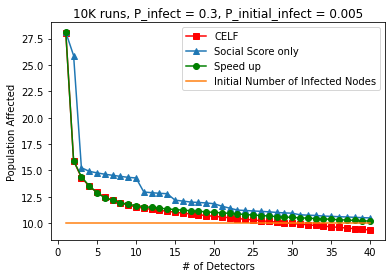

In [22]:
plt.plot(range(1, 41), celf_population_point005_point3, label="CELF", marker = "s", color="red")
plt.plot(range(1, 41), social_population_point005_point3, label="Social Score only", marker = "^")
plt.plot(range(1, 41), speedup_population_point005_point3, label="Speed up", marker="o", color="green")
plt.plot(range(1,41), np.ones(40)*10, label="Initial Number of Infected Nodes")
plt.title("10K runs, P_infect = 0.3, P_initial_infect = 0.005")
plt.ylabel("Population Affected")
plt.xlabel("# of Detectors")
plt.legend()

In [23]:
celf_1k_runtime =  celf_population_runtimes_point005_point3

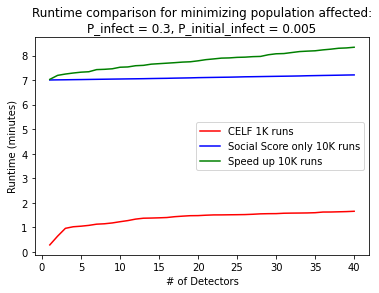

In [24]:
plt.plot(range(1,41), celf_1k_runtime, label="CELF 1K runs", color="red")
plt.plot(range(1,41), [runtime + 7 for runtime in social_population_runtimes_point005_point3], label="Social Score only 10K runs", color="blue")
plt.plot(range(1,41), [runtime + 7 for runtime in speedup_population_runtimes_point005_point3], label="Speed up 10K runs", color="green")
plt.title("Runtime comparison for minimizing population affected:\nP_infect = 0.3, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

In [25]:
social_population_runtimes_point005_point3

[0.004450011253356934,
 0.009101823965708414,
 0.012668204307556153,
 0.017282267411549885,
 0.020968230565388997,
 0.025965392589569092,
 0.03065446615219116,
 0.03512579600016276,
 0.0399167537689209,
 0.04395295778910319,
 0.048568860689798994,
 0.0525428573290507,
 0.05676878293355306,
 0.06282021204630533,
 0.0679573138554891,
 0.07223591009775797,
 0.07938448588053386,
 0.0846235434214274,
 0.09042392174402873,
 0.09891582727432251,
 0.10442746877670288,
 0.10939838488896687,
 0.114328666528066,
 0.1186797817548116,
 0.12543169657389322,
 0.13360072374343873,
 0.13776647647221882,
 0.1428848147392273,
 0.1481423775355021,
 0.1531176447868347,
 0.15772362550099692,
 0.16256317297617595,
 0.16805696487426758,
 0.17678917249043782,
 0.18235592047373453,
 0.1884872039159139,
 0.19351359208424887,
 0.19904935757319134,
 0.20543500582377117,
 0.21045324007670085]

# Saving celf output

In [26]:
pickle.dump(celf_population_point001_point3, open("celf_population_point001_point3", "wb"))
pickle.dump(celf_population_runtimes_point001_point3, open("celf_population_runtimes_point001_point3", "wb"))
pickle.dump(celf_population_point005_point5, open("celf_population_point005_point5", "wb"))
pickle.dump(celf_population_runtimes_point005_point5, open("celf_population_runtimes_point005_point5", "wb"))
pickle.dump(celf_population_point005_point3, open("celf_population_point005_point3", "wb"))
pickle.dump(celf_population_runtimes_point005_point3, open("celf_population_runtimes_point005_point3", "wb"))
